# Spiking mushroom body workshop

Hello, this is the code and instructions for the spiking mushroom body model as seen in the paper: [Investigating visual navigation using spiking neural network models of the insect mushroom bodies.](https://www.frontiersin.org/journals/physiology/articles/10.3389/fphys.2024.1379977/full)

You can use the images provided on Canvas. They are taken from this public database: https://github.com/BrainsOnBoard/sussex-ftl-dataset/tree/master/new-routes/ftl-1. These were taken while driving a robot around the Future-Technologies-Lab (FTL). Position within the FTL was also stored for each image taken; this information is found in the CSV file provided on Canvas. You can also find it here https://github.com/BrainsOnBoard/sussex-ftl-dataset/blob/master/new-routes/ftl-1/database_entries.csv

You can use this notebook or a standalone Python file.

In [1]:
#%% imports
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import cv2
from copy import copy #allows copying of a python object
from six import iteritems # may not be needed
import re
import pandas as pd
import os
from pygenn import (create_current_source_model, create_neuron_model,
                    create_weight_update_model, init_sparse_connectivity,
                    init_postsynaptic, init_weight_update, GeNNModel)


C:\ProgramData\miniconda3\Lib\site-packages\setuptools\_distutils\_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(


### Imports
Below you will find the imports needed for the following code. Make sure you have Genn 5 installed not the 4.X version. Six/iteritems may not be needed. If compatibility/versions are an issue, please see the provided "mb_workshop_env_requirements.yml" conda environment file. Note I use this environment for a variety of things, so most of what is listed there is not needed for this workshop.

In [2]:
def check_learn(image_path, res = (40,8), plot=True, input_scale=0.003,
                ifn_thresh=200,a_value=0.05, vpn_kc_weight=0.25,
                ret_g=False, ret_mpoten=False, ret_isyn=False):
    """
    Function
    Checks a model is learning with a single image, or train a model on a series of images.
    Parameters
    ----------
    image_path : 2D numpy array, or path string 
        Input image to check learning for a single image, or input directory to train on a directory of images.
    res : Tuple, optional
        Resolution to change input image to.
    input_scale : Float, optional
        Scale the the input current into the VPNs is multiplied by. The default is 0.003.
    ifn_thresh : Integer, optional
        Threshold for how many KCs fire before the inhibitory feedback neuron inhibits the kenyon cells. The default is 200.
    a_value : Float, optional
        Value of A which defines the magnitude of the weight change in the learning rule
    vpn_kc_weight : Float, optional
        Static weights between the VPN and KC cells. The default is 0.25.
    plot : Bool, optional
        Whether you want to plot the presentation of the 2 stimuli. The default is True.
    ret_g : Bool, optional
        Whether you want to return the synaptic weight matrix. The default is False.
    
    Returns
    -------
    Returns a pandas dataframe with the spiking activity details of each population of neurons.
    
    """
    
    #-----------------------------------------------
    # Neuron population parameters
    #-----------------------------------------------
    
    # Simulation time step
    dt = 0.1
    # how long we will show the model a stimulus in milliseconds
    PRESENT_TIME_MS = 20
    
    #% define LIF neuron parameters
    LIF_PARAMS = {
        "C": 0.2, #capacitance in nanofarad
        "TauM": 10.0, # tau larger leaks slower
        "Vrest": -60.0, # resting membrane potential?
        "Vreset": -60.0,
        "Vthresh": -50.0,
        "Ioffset": 0.0,
        "TauRefrac": 2.0} #refractory period. I believe in milliseconds. How long until it can spike again
    
    # increasing PN the refractory time so they can't spike too often
    VPN_PARAMS = copy(LIF_PARAMS)
    VPN_PARAMS["TauRefrac"] = 20.0
    
    # want the IFN (inhibitory feedback neuron) to inhibit the KCs after (x) number of kc spikes
    # KC to IFN synapses use DELTA currents; pushing their excitation at once,
    # the IFN threshold can be basically a counter for how many kc you want to fire.
    IFN_PARAMS = {
        "Vthresh": ifn_thresh}
    
    #vpn population number comes from the resolution of the input image
    NUM_VPN = res[0]*res[1] #number of projection neurons.
    # this is the output neuron. Low activity means familiar, high activity means unfamiliar 
    NUM_MBON = 1 # aka mushroom body output neurons.
    NUM_KC = 20000 # number of kenyon cells
    
    # get initial parameters for leaky integrate and fire neurons
    lif_init = {"V": VPN_PARAMS["Vreset"], "RefracTime": 0.0} #initial voltage and refractory time
    #initial voltage parameter for integrate and fire neuron (IFN)
    if_init = {"V": 0.0} # need to set for the IFN model too if adding in
    
    #---------------------------------------------
    # Synapse parameters
    #---------------------------------------------
    
    # initial weight for synapse between vpns and kcs
    VPN_KC_WEIGHT = vpn_kc_weight #may need to adjust starting value based on ardin
    VPN_KC_TAU_SYN = 3.0
    #changing to 10 for 10 ramdom connections between VPN and KC neurons.
    VPN_KC_FAN_IN = 10 #why FAN_IN? initialisation
    
    KC_MBON_TAU_SYN = 15.0
    #dictionary of parameters needed in the weight update class I'm creating
    KC_MBON_PARAMS = {  
        "tauPlus":2, #tau plus is time constant that affects the decay of the curve. (For pre fires before post)
        "tauMinus":2,# in ,milliseconds tau minus is time constant that affects the decay of the curve. (For pre fires after post)
        "aPlus":-a_value, # a plus scales the magnitude of the weight change (For pre fires before post)
        "aMinus":a_value,# a minus scales the magnitude of the weight change (For pre fires after post)
        "wMin":0.00, # the min values synaptic weights can go to 
        "wMax":0.05} # the max values synaptic weights can go to
    
    #---------------------------------------------
    # Custom neuron, learning rule, and current source models
    #---------------------------------------------
    
    # creating the learning rule
    # remember the overarching equation is the change of synaptic weights,
    # as a function of the relative timings of pre and postsynaptic firing.
    # note this is just creating the weight update model to be later used in the synapse
    anti_hebbian = create_weight_update_model(
        #name of model
            "anti-hebbian",
            params=["tauPlus", "tauMinus", "aPlus", "aMinus", "wMin", "wMax"],
            # g is synaptic conductance
            vars=[("g", "scalar")],
            #
            pre_spike_syn_code=
            """
            addToPost(g);
            const scalar dt = t - st_post;
            if (dt > 0) {
                const scalar timing = exp(-dt / tauMinus);
                const scalar newWeight = g - (aMinus * timing);
                g = fmax(wMin, fmin(wMax, newWeight));
                }
                """,
            post_spike_syn_code="""
                const scalar dt = t - st_pre;
                if (dt > 0) {
                    const scalar timing = exp(-dt / tauPlus);
                    const scalar newWeight = g + (aPlus * timing);
                    g = fmax(wMin, fmin(wMax, newWeight));
                }
                """)        
    
    #% implent the IFN type of integrate and fire neuron
    # Integrate and fire, (simple not leaky)
    if_model = create_neuron_model(
        "IF",
        params=["Vthresh"],
        vars=[("V", "scalar")],
        sim_code= #bewlow add incoming synaptic current to voltage
        """
        V += Isyn;
        """,
        threshold_condition_code= #when threshold reached it emits a spike
        """
        V >= Vthresh
        """,
        reset_code= #ten it is set to 0
        """
        V= 0.0;
        """)
        
    #% creating current source to deliver input to network.
    # This has to be done before the model is built and loaded
    
    cs_model = create_current_source_model(
        "cs_model",
        vars=[("magnitude", "scalar")],
        injection_code="injectCurrent(magnitude);")
    
    
    #---------------------------------------------
    # model building: population
    #---------------------------------------------
    #% starting model
    # name determines what the CODE folder is called in working directory when you run it
    model = GeNNModel("float", "mb_cl")
    #time steps
    model.dt = dt
    
    #% adding in neuron populations
    #adding population of visual projection neurons
    vpn = model.add_neuron_population("vpn", NUM_VPN, "LIF", VPN_PARAMS, lif_init) #projection neurons
    #add in kenyon cell populations
    kc = model.add_neuron_population("kc", NUM_KC, "LIF", LIF_PARAMS, lif_init)
    # add mushroom body output neuron, AKA extrisic neuron
    mbon = model.add_neuron_population("mbon", NUM_MBON, "LIF", LIF_PARAMS, lif_init)
    # add one inhibitory neuron
    ifn = model.add_neuron_population("ifn", 1, if_model, IFN_PARAMS, if_init)
    
    #turn on recording for these population
    #% # Turn on spike recording, so we see what they're doing
    vpn.spike_recording_enabled = True
    kc.spike_recording_enabled = True #need it on for both populations
    mbon.spike_recording_enabled = True
    ifn.spike_recording_enabled = True
    
    
    #---------------------------------------------
    # model building: adding synapses
    #---------------------------------------------
    
    # vpn to kc neurons,
    vpn_kc = model.add_synapse_population("vpn_kc", "SPARSE",
                                         vpn, kc,
    # this static pulse keeps it simple and is non learning.
                                         init_weight_update("StaticPulseConstantWeight", {"g": VPN_KC_WEIGHT}),
    #expcurr here is the postsynaptic model in use here, dict is parameter values for postsynaptic models, empty dict is initial values
                                         init_postsynaptic("ExpCurr", {"tau": VPN_KC_TAU_SYN}),
    #this is connectivity initialiser function. The string refers to connectivity with fixed number of random synapses per collumn in connectivity matrix
                                         init_sparse_connectivity("FixedNumberPreWithReplacement", {"num": VPN_KC_FAN_IN}))
    
    # synapses the kc and the IFN. recurrent inhibition
    # dense connectivity because all the kenyon cells are connected to the IFN
    kc_ifn = model.add_synapse_population("kc_ifn", "DENSE", 
                                          kc, ifn, 
                                          init_weight_update("StaticPulseConstantWeight", {"g": 1.0}), 
                                          init_postsynaptic("DeltaCurr")) #delta current where all current dumped into neuron in one single timestep
    
    # synapse for ifn to inhbit the KCs
    ifn_kc = model.add_synapse_population("ifn_kc", "DENSE", 
                                          ifn, kc,
                                          init_weight_update("StaticPulseConstantWeight", {"g": -5.0}), # -5 is large inhibitory weight
                                          init_postsynaptic("ExpCurr", {"tau": 5.0})) #the exponential synapse spreads out the inhibition for a few timesteps
    
    
    # define weight update information to go in the synapse
    #this is where i'd have to load previously made weight matrixes also
    kc_mbon_weight_update = init_weight_update(anti_hebbian, KC_MBON_PARAMS, {"g": np.ones(NUM_KC*NUM_MBON) * 0.005})
    
    # adding plastic connection between the kenyon cells and the mbons
    # dense individual g so each synapse has their own individual weights. 
    # using the anti_hebbian rule defined previously
    kc_mbon = model.add_synapse_population("kc_mbon", "DENSE",
                                           kc, mbon,
                                           kc_mbon_weight_update,
                                           init_postsynaptic("ExpCurr", {"tau": KC_MBON_TAU_SYN}))
    #model.build()
    #%
    #%
    #use previously made current source model and input into the vpns
    vpn_input = model.add_current_source("vpn_input", cs_model , vpn , {}, {"magnitude": 0.0})
    
    
    # Convert present time into timesteps
    present_timesteps = int(round(PRESENT_TIME_MS / model.dt))
    
    #input scale to create a larger stimulus from the image presented to model
    INPUT_SCALE = input_scale
    
    #% Build model and load it
    model.build()
    #make sure it is recording data for the time we present the stimulus
    model.load(num_recording_timesteps=present_timesteps)
    #model builds and loads corectly
    
    #---------------------------
    #% Simulation section functions
    #---------------------------
    
    #need to reset spike times as well
    def reset_spike_times(pop):
        pop.spike_times.view[:] = -np.finfo(np.float32).max
        pop.spike_times.push_to_device()
    
    def reset_neuron(pop, var_init):
        # Reset variables. iteritems is imported from the six module
            for var_name, var_val in var_init.items():
                var = pop.vars[var_name]
                # Reset to initial value and push to device
                var.view[:] = var_val
                var.push_to_device()
    
    #this will reset
    def reset_out_post(pop):
        pop.out_post.view[:] = 0.0
        pop.out_post.push_to_device()
    
    #% load in image data as stimulus and transform it
    image = cv2.imread(image_path, 0)
    small = cv2.resize(image, res)
    # the 255 inverses the image
    flat = 255 - small.flatten()
    
    # input scale increases the power of the input current from the image
    vpn_input.vars["magnitude"].view[:] = flat * INPUT_SCALE
    #genn needs manual management of CPU to GPU
    vpn_input.vars["magnitude"].push_to_device()
    
    #breakpoint()
    #create list to store data frames from the simulation, will concatenate after
    df_list = []
    
    # simulate for 2 trials
    for trial in range(2):
            #extract membrane potential
        if ret_mpoten==True and trial==0:
            v_vpn = np.empty((200, 320))
            vpn_view = vpn.vars["V"].view
            
            v_kc = np.empty((200, 20000))
            kc_view = kc.vars["V"].view
            
            v_mbon = np.empty((200, 1))
            mbon_view = mbon.vars["V"].view
            
            v_ifn = np.empty((200, 1))
            ifn_view = ifn.vars["V"].view
            
            #extract current information
        if ret_isyn==True and trial==0:
            i_mbon = np.empty((200, 1))
            kc_mbon.pull_in_syn_from_device()
            i_mbon_view = kc_mbon.in_syn
            
            kc_ifn.pull_in_syn_from_device()
            i_ifn = np.empty((200, 1))
            i_ifn_view = kc_ifn.in_syn
        # Simulate timesteps
        for i in range(present_timesteps):
            #advance model by one timestep
            model.step_time()
            if ret_mpoten==True and trial==0:
                vpn.vars["V"].pull_from_device()
                v_vpn[model.timestep - 1,:]=vpn_view[:]
                
                kc.vars["V"].pull_from_device()
                v_kc[model.timestep - 1,:]=kc_view[:]
                
                mbon.vars["V"].pull_from_device()
                v_mbon[model.timestep - 1,:]=mbon_view[:]
                
                ifn.vars["V"].pull_from_device()
                v_ifn[model.timestep - 1,:]=ifn_view[:]
                
            if ret_isyn==True and trial==0:
                kc_mbon.pull_in_syn_from_device()
                i_mbon[model.timestep - 1,:]=i_mbon_view[:]
                
                kc_ifn.pull_in_syn_from_device()
                i_ifn[model.timestep - 1,:]=i_ifn_view[:]
            
        # Reset neuron state for next stimuli, instead of just waiting for them to reset "naturally"
        reset_neuron(vpn, lif_init)
        reset_neuron(kc, lif_init) #resetting kenyon cells too
        reset_neuron(ifn, if_init) # reset IFN neuron
        reset_neuron(mbon, lif_init)
        
        #reset spike times (may not need to do this in the "test function")
        reset_spike_times(kc)
        reset_spike_times(mbon)
        
        #reset the state of the synapses
        reset_out_post(vpn_kc)
        #don't need to reset kc to IFN reset_out_post(kc_ifn)
        reset_out_post(ifn_kc)
        reset_out_post(kc_mbon)
        
        # Download spikes from GPU
        model.pull_recording_buffers_from_device();
        
        # Plot VPN, kc and MBON spikes. Share x should make x axis same scale
        
        
        #extract recording data from each population
        vpn_spike_times, vpn_spike_ids = vpn.spike_recording_data[0]
        kc_spike_times, kc_spike_ids = kc.spike_recording_data[0]
        mbon_spike_times, mbon_spike_ids = mbon.spike_recording_data[0]
        ifn_spike_times, ifn_spike_ids = ifn.spike_recording_data[0]
        
        
        #% make an array corresponding to each column of the data frame
        
        #this array will be the column of population names
        pop_name_array = np.concatenate((np.repeat("vpn", len(vpn_spike_times)), np.repeat("kc", len(kc_spike_times)),
        np.repeat("mbon", len(mbon_spike_times)), np.repeat("ifn", len(ifn_spike_times))))
        
        #this array will be the column of trial number indicators
        trial_no_array = np.concatenate((np.repeat(trial, len(vpn_spike_times)), np.repeat(trial, len(kc_spike_times)),
        np.repeat(trial, len(mbon_spike_times)), np.repeat(trial, len(ifn_spike_times))))
        
        #this array will be the column of spike times
        spike_times_array = np.concatenate((vpn_spike_times, kc_spike_times, mbon_spike_times, ifn_spike_times))
        
        #this array will be the column of spike IDs
        spike_ids_array =  np.concatenate((vpn_spike_ids, kc_spike_ids, mbon_spike_ids, ifn_spike_ids))
        
        #% make dataframe for a single trial.
        
        trial_df = pd.DataFrame({"pop": pop_name_array, "trial":trial_no_array, "spike_id": spike_ids_array,
                           "spike_time":spike_times_array,})
        
        
        #% add this dataframe to master list containing information from every trial
        df_list.append(trial_df)
    
    #%
            #plot if the user wants
        if plot==True:
        
            fig, axes = plt.subplots(3, sharex=True)
            axes[0].scatter(vpn_spike_times, vpn_spike_ids, s=1)
            axes[0].set_ylabel("VPN")
            axes[0].set_title("Resolution for VPNs "+str(res))
            #plot kenyon cells 
            axes[1].scatter(kc_spike_times, kc_spike_ids, s=1)
            axes[1].set_xlabel("Time [ms]")
            axes[1].set_ylabel("KC")
            axes[1].set_title("VPN to KC weight: "+str(vpn_kc_weight))
            # plot in the IFN
            if ifn_spike_times.size != 0:
                for ifn_spike in ifn_spike_times:
                    line1 = axes[1].axvline(x=ifn_spike, color="red")
                axes[1].legend([line1], ["IFN spike at threshold "+str(ifn_thresh)])
            #plot MBONS
            axes[2].scatter(mbon_spike_times, mbon_spike_ids, s=2)
            axes[2].set_ylabel("MBONS")
            
            #give corresponding number for plot title
            if trial == 0:        
                plt.title("First presentation of stimuli")
            if trial == 1:
                plt.title("Second presentation of stimuli")
            plt.tight_layout()
            plt.show()
    
    #make the master dataframe by concatenating collected dfs
    activity_df = pd.concat(df_list)
    
    if ret_mpoten==True:
        return v_vpn, v_kc, v_mbon, v_ifn
    if ret_isyn==True:
        return i_mbon, i_ifn
    else:
        return activity_df

### The "check learn" function

Above is defines function to test whether things are installed correctly and learning is working in the model. It accepts a single image, downscales it, trains the model on that image, then tests the model on it. It also outputs a raster plot where you can see the activity of the 3 different populations of neurons. It produces a raster both for the train and the test, and outputs a dataframe containing every spike that occured. Since the connection between the Kenyon cells and the MBON is mediated by a anti-hebbian learning rule, when the MBON doesn't respond it means it is categorising something as familiar.

Things to do/try:
* Input one image and see if the model is working
* View the docstrings to check how different parameter change the spiking activity seen in the raster.
* Can you change the parameters to prevent learning?

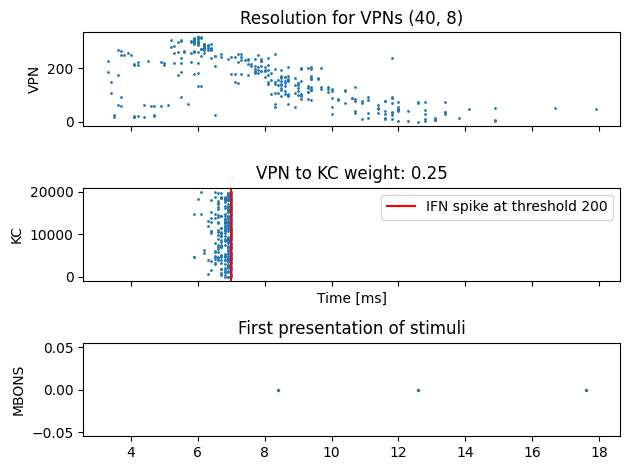

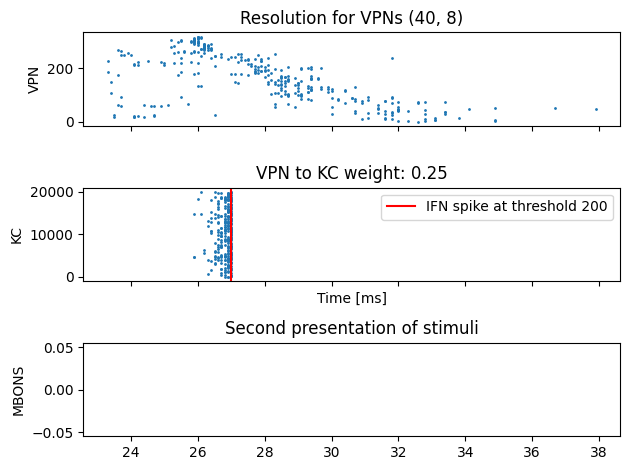

,pop,trial,spike_id,spike_time
0,vpn,0,187,3.3
1,vpn,0,227,3.3
2,vpn,0,107,3.4
3,vpn,0,147,3.4
4,vpn,0,23,3.5
...,...,...,...,...
604,kc,1,19258,27.0
605,kc,1,19747,27.0
606,kc,1,19922,27.0
607,kc,1,19962,27.0


In [3]:
check_learn(r"snapshots\snapshot_0.png") #input a path to a single image
#play with parameters
#check_learn(image_path, res = (40,8), plot=True, input_scale=0.003,
                #ifn_thresh=200,a_value=0.05, vpn_kc_weight=0.25,
                #ret_g=False, ret_mpoten=False, ret_isyn=False)

In [4]:
#%% function to take a path to a folder of images, and output a sorted list of files

def sort_folder_paths(image_folder_path):
    """
    Parameters
    ----------
    image_folder_path : string
        Path to a folder containing numbered image files. Has to be .png or .jpg image files.

    Returns
    -------
    List
        Returns a sorted list of full paths to images in the given folder

    """

    #image_folder_path = r"C:\Users\oj74\Documents\oj_rotation1\sussex-ftl-dataset\new-routes\ftl-1"
    
    img_file_list = []
    # return all files as a list
    for file in os.listdir(image_folder_path):
    	# check the files which are end with specific extension
    	if file.endswith(".png") or file.endswith(".jpg"):
    		# print path name of selected files
    		img_file_list.append(file)
            
            
    #sort in a human way
    def tryint(s):
        try:
            return int(s)
        except:
            return s
    
    def alphanum_key(s):
        """ Turn a string into a list of string and number chunks.
            "z23a" -> ["z", 23, "a"]
        """
        return [ tryint(c) for c in re.split('([0-9]+)', s) ]
    
    def sort_nicely(l):
        """ Sort the given list in the way that humans expect.
        """
        l.sort(key=alphanum_key)
        print("input list has been sorted")
        
    sort_nicely(img_file_list)

    return img_file_list


The above function takes a directory of files and sorts them into an ordered list. Often when reading in folders, the file list you get back in python is not ordered correctly.

In [5]:
# a script to make a function to train the mushroom body model and output the KC to MBON weights
#%
def train_mb(image_folder_path, tr_number=False, neural_filter_path=False, img_reg=False, activity_out=False, res=(40,8)
             , save_wm_name=False, w_per_image_out=False, input_scale=0.003,
             ifn_thresh=200, a_value=0.05, vpn_kc_weight=0.25):
    """
    Function
    Train a model on a folder of images. And save the state of the network at the end of training.
    Parameters
    ----------
    image_folder_path : TYPE
        Input directory where series of route images are stored.
    res : TYPE
        Resolution to change input image to.
    input_scale : TYPE, optional
        Scale the the input current into the VPNs is multiplied by. The default is 0.003.
    ifn_thresh : TYPE, optional
        Threshold for how many KCs fire before the gabaergic inhibitory neuron inhibits the kenyon cells. The default is 200.
    a_value:
        Value of A which defines the magnitude of the weight change in the learning rule
    vpn_kc_weight : TYPE, optional
        Static weights between the VPN and KC cells. The default is 0.25.
    save_wm_name : TYPE, optional
        Name of npy file with weight matrix output. The default is False.
    tr_number:
        Number of files you wish to train the model on.

    Returns
    -------
    Returns the weight matrix between the kenyon cells and the MBONs. Optionally saves the matrix to a new file.

    """
    #-----------------------------------------------
    # Neuron population parameters
    #-----------------------------------------------
    
    # Simulation time step
    dt = 0.1
    # how long we will show the model a stimulus in milliseconds
    PRESENT_TIME_MS = 20
    
    #% define LIF neuron parameters
    LIF_PARAMS = {
        "C": 0.2, #capacitance in nanofarad
        "TauM": 10.0, # tau larger leaks slower
        "Vrest": -60.0, # resting membrane potential?
        "Vreset": -60.0,
        "Vthresh": -50.0,
        "Ioffset": 0.0,
        "TauRefrac": 2.0} #refractory period. I believe in milliseconds. How long until it can spike again
    
    # increasing PN the refractory time so they can't spike too often
    VPN_PARAMS = copy(LIF_PARAMS)
    VPN_PARAMS["TauRefrac"] = 20.0
    
    # want the IFN (inhibitory feedback neuron) to inhibit the KCs after (x) number of kc spikes
    # KC to IFN synapses use DELTA currents; pushing their excitation at once,
    # the IFN threshold can be basically a counter for how many kc you want to fire.
    IFN_PARAMS = {
        "Vthresh": ifn_thresh}
    
    #% adding in populations
    if neural_filter_path != False:
        neural_filter = np.load(neural_filter_path)
        NUM_VPN = neural_filter.shape[0]
    else:
        #this number comes from the resolution of the input image
        NUM_VPN = res[0]*res[1] #number of projection neurons.
    
    
    # this is the output neuron. Low activity means familiar, high activity means unfamiliar 
    NUM_MBON = 1 # aka mushroom body output neurons.
    NUM_KC = 20000 # number of kenyon cells
    
    # get initial parameters for leaky integrate and fire neurons
    lif_init = {"V": VPN_PARAMS["Vreset"], "RefracTime": 0.0} #initial voltage and refractory time
    #initial voltage parameter for integrate and fire neuron (IFN)
    if_init = {"V": 0.0} # need to set for the IFN model too if adding in
    
    #---------------------------------------------
    # Synapse parameters
    #---------------------------------------------
    
    # initial weight for synapse between vpns and kcs
    VPN_KC_WEIGHT = vpn_kc_weight #may need to adjust starting value 
    VPN_KC_TAU_SYN = 3.0
    #changing to 10 for 10 ramdom connections between VPN and KC neurons.
    VPN_KC_FAN_IN = 10 #why FAN_IN? initialisation
    
    KC_MBON_TAU_SYN = 15.0
    #dictionary of parameters needed in the weight update class I'm creating
    KC_MBON_PARAMS = {  
        "tauPlus":2, #tau plus is time constant that affects the decay of the curve. (For pre fires before post)
        "tauMinus":2,# in ,milliseconds tau minus is time constant that affects the decay of the curve. (For pre fires after post)
        "aPlus":-a_value, # a plus scales the magnitude of the weight change (For pre fires before post)
        "aMinus":a_value,# a minus scales the magnitude of the weight change (For pre fires after post)
        "wMin":0.00, # the min values synaptic weights can go to 
        "wMax":0.05} # the max values synaptic weights can go to
    
    #---------------------------------------------
    # Custom neuron, learning rule, and current source models
    #---------------------------------------------
    
    # creating the learning rule
    # remember the overarching equation is the change of synaptic weights,
    # as a function of the relative timings of pre and postsynaptic firing.
    # note this is just creating the weight update model to be later used in the synapse
    anti_hebbian = create_weight_update_model(
        #name of model
            "anti-hebbian",
            params=["tauPlus", "tauMinus", "aPlus", "aMinus", "wMin", "wMax"],
            # g is synaptic conductance
            vars=[("g", "scalar")],
            #
            pre_spike_syn_code=
            """
            addToPost(g);
            const scalar dt = t - st_post;
            if (dt > 0) {
                const scalar timing = exp(-dt / tauMinus);
                const scalar newWeight = g - (aMinus * timing);
                g = fmax(wMin, fmin(wMax, newWeight));
                }
                """,
            post_spike_syn_code="""
                const scalar dt = t - st_pre;
                if (dt > 0) {
                    const scalar timing = exp(-dt / tauPlus);
                    const scalar newWeight = g + (aPlus * timing);
                    g = fmax(wMin, fmin(wMax, newWeight));
                }
                """)        
    
    #% implent the IFN type of integrate and fire neuron
    # Integrate and fire, (simple not leaky)
    if_model = create_neuron_model(
        "IF",
        params=["Vthresh"],
        vars=[("V", "scalar")],
        sim_code= #bewlow add incoming synaptic current to voltage
        """
        V += Isyn;
        """,
        threshold_condition_code= #when threshold reached it emits a spike
        """
        V >= Vthresh
        """,
        reset_code= #ten it is set to 0
        """
        V= 0.0;
        """)
        
    #% creating current source to deliver input to network.
    # This has to be done before the model is built and loaded
    
    cs_model = create_current_source_model(
        "cs_model",
        vars=[("magnitude", "scalar")],
        injection_code="injectCurrent(magnitude);")
    
    
    #---------------------------------------------
    # model building: population
    #---------------------------------------------
    #% starting model
    # name determines what the CODE folder is called in working directory when you run it
    model = GeNNModel("float", "mb_cl")
    #time steps
    model.dt = dt
    
    #% adding in neuron populations
    #adding population of visual projection neurons
    vpn = model.add_neuron_population("vpn", NUM_VPN, "LIF", VPN_PARAMS, lif_init) #projection neurons
    #add in kenyon cell populations
    kc = model.add_neuron_population("kc", NUM_KC, "LIF", LIF_PARAMS, lif_init)
    # add mushroom body output neuron, AKA extrisic neuron
    mbon = model.add_neuron_population("mbon", NUM_MBON, "LIF", LIF_PARAMS, lif_init)
    # add one inhibitory neuron
    ifn = model.add_neuron_population("ifn", 1, if_model, IFN_PARAMS, if_init)
    
    #turn on recording for these population
    #% # Turn on spike recording, so we see what they're doing
    vpn.spike_recording_enabled = True
    kc.spike_recording_enabled = True #need it on for both populations
    mbon.spike_recording_enabled = True
    ifn.spike_recording_enabled = True
    
    
    #---------------------------------------------
    # model building: adding synapses
    #---------------------------------------------
    
    # vpn to kc neurons,
    vpn_kc = model.add_synapse_population("vpn_kc", "SPARSE",
                                         vpn, kc,
    # this static pulse keeps it simple and is non learning.
                                         init_weight_update("StaticPulseConstantWeight", {"g": VPN_KC_WEIGHT}),
    #expcurr here is the postsynaptic model in use here, dict is parameter values for postsynaptic models, empty dict is initial values
                                         init_postsynaptic("ExpCurr", {"tau": VPN_KC_TAU_SYN}),
    #this is connectivity initialiser function. The string refers to connectivity with fixed number of random synapses per collumn in connectivity matrix
                                         init_sparse_connectivity("FixedNumberPreWithReplacement", {"num": VPN_KC_FAN_IN}))
    
    # synapses the kc and the IFN. recurrent inhibition
    # dense connectivity because all the kenyon cells are connected to the IFN
    kc_ifn = model.add_synapse_population("kc_ifn", "DENSE", 
                                          kc, ifn, 
                                          init_weight_update("StaticPulseConstantWeight", {"g": 1.0}), 
                                          init_postsynaptic("DeltaCurr")) #delta current where all current dumped into neuron in one single timestep
    
    # synapse for ifn to inhbit the KCs
    ifn_kc = model.add_synapse_population("ifn_kc", "DENSE", 
                                          ifn, kc,
                                          init_weight_update("StaticPulseConstantWeight", {"g": -5.0}), # -5 is large inhibitory weight
                                          init_postsynaptic("ExpCurr", {"tau": 5.0})) #the exponential synapse spreads out the inhibition for a few timesteps
    
    
    # define weight update information to go in the synapse
    #this is where i'd have to load previously made weight matrixes also
    kc_mbon_weight_update = init_weight_update(anti_hebbian, KC_MBON_PARAMS, {"g": np.ones(NUM_KC*NUM_MBON) * 0.005})
    
    # adding plastic connection between the kenyon cells and the mbons
    # dense individual g so each synapse has their own individual weights. 
    # using the anti_hebbian rule defined previously
    kc_mbon = model.add_synapse_population("kc_mbon", "DENSE",
                                           kc, mbon,
                                           kc_mbon_weight_update,
                                           init_postsynaptic("ExpCurr", {"tau": KC_MBON_TAU_SYN}))
    #model.build()
    #%
    #%
    #use previously made current source model and input into the vpns
    vpn_input = model.add_current_source("vpn_input", cs_model , vpn , {}, {"magnitude": 0.0})

    
    # Convert present time into timesteps
    present_timesteps = int(round(PRESENT_TIME_MS / model.dt))
    
    #input scale to create a larger stimulus from the image presented to model
    INPUT_SCALE = input_scale
    
    #% Build model and load it
    model.build()
    #make sure it is recording data for the time we present the stimulus
    model.load(num_recording_timesteps=present_timesteps)
    #model builds and loads corectly
    #%    

    #---------------------------
    #% Neuron Simulation functions
    #---------------------------
    
    #need to reset spike times as well
    def reset_spike_times(pop):
        pop.spike_times.view[:] = -np.finfo(np.float32).max
        pop.spike_times.push_to_device()
    
    def reset_neuron(pop, var_init):
        # Reset variables. iteritems is imported from the six module
            for var_name, var_val in var_init.items():
                var = pop.vars[var_name]
                # Reset to initial value and push to device
                var.view[:] = var_val
                var.push_to_device()
    
    #this will reset
    def reset_out_post(pop):
        pop.out_post.view[:] = 0.0
        pop.out_post.push_to_device()

    #---------------------------
    #% Loading images and simulating images
    #---------------------------

    #load images into a list
    image_files = sort_folder_paths(image_folder_path)
   
    #conditional for the amount of images you want to train on
    if tr_number!=False:
        image_files = image_files[0:tr_number]
    
    if activity_out==True:    
        #create list to store data frames from the simulation, will concatenate after
        df_list = []

    if w_per_image_out== True:
        weight_list = []

    for file in image_files:
        # make full path with directory and image
        path_to_image = os.path.join(image_folder_path,file)
        image = cv2.imread(path_to_image, 0)
        if neural_filter_path == False:
            if img_reg == True:
                resized = cv2.resize(image, res)
                small = (resized - np.mean(resized)) / np.std(resized)
            else:
                small = cv2.resize(image, res)
            # the 255 inverses the image
            flat = 255 - small.flatten()
        else: #take full res image
            temp_flat = (255 - image).flatten()
            #apply filter to flattened image
            filter_output = np.matmul(neural_filter, temp_flat)
            flat = filter_output
        
        print("training on file "+file)
        
        # input scale increases the power of the input current from the image
        vpn_input.vars["magnitude"].view[:] = flat * INPUT_SCALE
        #genn needs manual management of CPU to GPU
        vpn_input.vars["magnitude"].push_to_device()
        
        #need time to move for anything to happen
        for i in range(present_timesteps):
            #advance model by one timestep
            model.step_time()
        
        # Reset neuron state for next stimuli, instead of just waiting for them to reset "naturally"
        reset_neuron(vpn, lif_init)
        reset_neuron(kc, lif_init) #resetting kenyon cells too
        reset_neuron(ifn, if_init) # reset ifn neuron
        reset_neuron(mbon, lif_init)
        
        #need to reset spike times when training
        reset_spike_times(kc)
        reset_spike_times(mbon)
        
        reset_out_post(vpn_kc)
        reset_out_post(kc_ifn)
        reset_out_post(ifn_kc)
        # resetting the synapse doesn't stop it from learning
        reset_out_post(kc_mbon)
        
        #check if weight change per image is wanted, if so collect weights for every image
        if w_per_image_out==True:
            kc_mbon.vars["g"].pull_from_device()
            temp_kc_mbon = kc_mbon.vars["g"].view 
            weight_list.append(temp_kc_mbon.copy())
        
        if activity_out==True:
            # Download spikes from GPU
            model.pull_recording_buffers_from_device();
            
            #extract recording data from each population
            vpn_spike_times, vpn_spike_ids = vpn.spike_recording_data[0]
            kc_spike_times, kc_spike_ids = kc.spike_recording_data[0]
            mbon_spike_times, mbon_spike_ids = mbon.spike_recording_data[0]
            ifn_spike_times, ifn_spike_ids = ifn.spike_recording_data[0]
            
            #% make an array corresponding to each column of the data frame
            #this array will be the column of population names
            pop_name_array = np.concatenate((np.repeat("vpn", len(vpn_spike_times)), np.repeat("kc", len(kc_spike_times)),
            np.repeat("mbon", len(mbon_spike_times)), np.repeat("ifn", len(ifn_spike_times))))
            
            #this array will be for the image file
            input_file_array = np.repeat(file, len(pop_name_array))
            
            #this array will be the column of spike times
            spike_times_array = np.concatenate((vpn_spike_times, kc_spike_times, mbon_spike_times, ifn_spike_times))
            
            #this array will be the column of spike IDs
            spike_ids_array =  np.concatenate((vpn_spike_ids, kc_spike_ids, mbon_spike_ids, ifn_spike_ids))
            
            #make dataframe with this information for response to a single images
            
            single_image_df = pd.DataFrame({"image_file": input_file_array,
                                                 "pop":pop_name_array, "spike_id":spike_ids_array,
                                                 "spike_time":spike_times_array})
                
            #% add this dataframe to master list containing information from every trial
            df_list.append(single_image_df)
        
    if w_per_image_out==True:
        w_p_img_array = np.asarray(weight_list)
    
    #this needs to be outside loop
    #% Download weights from GPU
    kc_mbon.vars["g"].pull_from_device()
    kc_mbon_g_view = kc_mbon.vars["g"].view
    
    print("model trained")
    #save weights from testing into a file. For later testing to load up into another simulation
    # name file with the weight matrix name from the wm_name variable
    if save_wm_name != False:
        np.save(save_wm_name, kc_mbon_g_view)
    
    #save connectivity matrix of VPN to KC
    vpn_kc.pull_connectivity_from_device()
    #get the presynapse and postsynapse activity
    vpn_kc_connectivity = np.vstack((vpn_kc.get_sparse_pre_inds(), vpn_kc.get_sparse_post_inds()))
    
    if activity_out==True:  
        #make the master dataframe by concatenating collected dfs
        activity_df = pd.concat(df_list)
    
    if activity_out==True and w_per_image_out==False:
        return kc_mbon_g_view.copy(), vpn_kc_connectivity, activity_df, 
    if w_per_image_out==True and activity_out==True:
        return kc_mbon_g_view.copy(), vpn_kc_connectivity, activity_df, w_p_img_array
    if w_per_image_out==True and activity_out==False:
        kc_mbon_g_view.copy(), vpn_kc_connectivity, w_p_img_array
    else:
        return kc_mbon_g_view.copy(), vpn_kc_connectivity

### The train_mb function
The above function is for more large scale training. It accepts a path to a folder, and trains on the images in that folder. By default this function outputs the KC to MBON weight matrix (this is what changed during learning), and VPN to KC connectivity matrix (this is initialised randomly, so we need to maintain this is training and testing). These need to be input into the 


Things to do/try:
* View the docstrings to check your options for different parameter changes.
* Start training on a low amount of images (edit tr number).
* When you change parameters make sure you maintain them between train and test.

In [6]:
# function to test mushroom body
def test_mb(image_folder, w_matrix, vpn_connections, neural_filter_path=False, img_reg=False, te_number = False, rotate=True, res=(40,8), input_scale=0.003, ifn_thresh=200, vpn_kc_weight=0.25):
    """
    Function that loads weights and then records the models responses to rotations of the input images.

    Parameters
    ----------
    image_folder : TYPE
        Folder of input images to be tested
    res : TYPE
        Input resolution inputs are to be tested at.
    w_matrix : TYPE
        Weights (g) between KC and MBONS to be loaded. Can be numpy array or path to numpy file.
    te_number:
        Number of images from directory that you wish to test
    input_scale : TYPE, optional
        Scale the the input current into the VPNs is multiplied by. The default is 0.003.
    ifn_thresh : TYPE, optional
        Threshold for how many KCs fire before the gabaergic inhibitory neuron inhibits the kenyon cells. The default is 200.
    vpn_kc_weight : TYPE, optional
        Static weights between the VPN and KC cell. The default is 0.25.
    rotate : 
        Whether to rotate the input images for testing or just test them in their original rotation.

        
    Returns
    -------
    Dataframe with activity of all neurons in the model in response to the stimulus

    """

    
    #-----------------------------------------------
    # Neuron population parameters
    #-----------------------------------------------
    
    # Simulation time step
    dt = 0.1
    # how long we will show the model a stimulus in milliseconds
    PRESENT_TIME_MS = 20
    
    #% define LIF neuron parameters
    LIF_PARAMS = {
        "C": 0.2, #capacitance in nanofarad
        "TauM": 10.0, # tau larger leaks slower
        "Vrest": -60.0, # resting membrane potential?
        "Vreset": -60.0,
        "Vthresh": -50.0,
        "Ioffset": 0.0,
        "TauRefrac": 2.0} #refractory period. I believe in milliseconds. How long until it can spike again
    
    # increasing PN the refractory time so they can't spike too often
    VPN_PARAMS = copy(LIF_PARAMS)
    VPN_PARAMS["TauRefrac"] = 20.0
    
    # want the IFN (inhibitory feedback neuron) to inhibit the KCs after (x) number of kc spikes
    # KC to IFN synapses use DELTA currents; pushing their excitation at once,
    # the IFN threshold can be basically a counter for how many kc you want to fire.
    IFN_PARAMS = {
        "Vthresh": ifn_thresh}
    
    #% adding in populations
    if neural_filter_path != False:
        neural_filter = np.load(neural_filter_path)
        NUM_VPN = neural_filter.shape[0]
    else:
        #this number comes from the resolution of the input image
        NUM_VPN = res[0]*res[1] #number of projection neurons.
    
    
    # this is the output neuron. Low activity means familiar, high activity means unfamiliar 
    NUM_MBON = 1 # aka mushroom body output neurons.
    NUM_KC = 20000 # number of kenyon cells
    
    # get initial parameters for leaky integrate and fire neurons
    lif_init = {"V": VPN_PARAMS["Vreset"], "RefracTime": 0.0} #initial voltage and refractory time
    #initial voltage parameter for integrate and fire neuron (IFN)
    if_init = {"V": 0.0} # need to set for the IFN model too if adding in
    
    #---------------------------------------------
    # Synapse parameters
    #---------------------------------------------
    
    # initial weight for synapse between vpns and kcs
    VPN_KC_WEIGHT = vpn_kc_weight #may need to adjust starting value 
    VPN_KC_TAU_SYN = 3.0
    #changing to 10 for 10 ramdom connections between VPN and KC neurons.
    VPN_KC_FAN_IN = 10 #why FAN_IN? initialisation
    
    KC_MBON_TAU_SYN = 15.0
    #dictionary of parameters needed in the weight update class I'm creating
    #dont need kc mbon parameters because this connection is non-learning
    
    #---------------------------------------------
    # Custom neuron, and current source models
    #---------------------------------------------
    
    # anti hebbian learning rule not needed   
    
    #% implent the IFN type of integrate and fire neuron
    # Integrate and fire, (simple not leaky)
    if_model = create_neuron_model(
        "IF",
        params=["Vthresh"],
        vars=[("V", "scalar")],
        sim_code= #bewlow add incoming synaptic current to voltage
        """
        V += Isyn;
        """,
        threshold_condition_code= #when threshold reached it emits a spike
        """
        V >= Vthresh
        """,
        reset_code= #ten it is set to 0
        """
        V= 0.0;
        """)
        
    #% creating current source to deliver input to network.
    # This has to be done before the model is built and loaded
    
    cs_model = create_current_source_model(
        "cs_model",
        vars=[("magnitude", "scalar")],
        injection_code="injectCurrent(magnitude);")
    
    
    #---------------------------------------------
    # model building: population
    #---------------------------------------------
    #% starting model
    # name determines what the CODE folder is called in working directory when you run it
    model = GeNNModel("float", "mb_cl")
    #time steps
    model.dt = dt
    
    #% adding in neuron populations
    #adding population of visual projection neurons
    vpn = model.add_neuron_population("vpn", NUM_VPN, "LIF", VPN_PARAMS, lif_init) #projection neurons
    #add in kenyon cell populations
    kc = model.add_neuron_population("kc", NUM_KC, "LIF", LIF_PARAMS, lif_init)
    # add mushroom body output neuron, AKA extrisic neuron
    mbon = model.add_neuron_population("mbon", NUM_MBON, "LIF", LIF_PARAMS, lif_init)
    # add one inhibitory neuron
    ifn = model.add_neuron_population("ifn", 1, if_model, IFN_PARAMS, if_init)
    
    #turn on recording for these population
    #% # Turn on spike recording, so we see what they're doing
    vpn.spike_recording_enabled = True
    kc.spike_recording_enabled = True #need it on for both populations
    mbon.spike_recording_enabled = True
    ifn.spike_recording_enabled = True
    
    #---------------------------------------------
    # model building: adding synapses
    #---------------------------------------------
    
    # vpn to kc neurons,
    # sparse global g means sparse connections with a global setting for weights (to use less memory)
    # NO.delay is the amount of steps to delay, here none
    vpn_kc = model.add_synapse_population("vpn_kc", "SPARSE",
                                         vpn, kc,
    # this static pulse keeps it simple and is non learning.
                                         init_weight_update("StaticPulseConstantWeight", {"g": VPN_KC_WEIGHT}),
    #expcurr here is the postsynaptic model in use here, dict is parameter values for postsynaptic models, empty dict is initial values
                                         init_postsynaptic("ExpCurr", {"tau": VPN_KC_TAU_SYN}))
    vpn_kc.set_sparse_connections(vpn_connections[0], vpn_connections[1])
    
    # synapses the kc and the IFN. recurrent inhibition
    # dense connectivity because all the kenyon cells are connected to the IFN
    kc_ifn = model.add_synapse_population("kc_ifn", "DENSE", 
                                          kc, ifn, 
                                          init_weight_update("StaticPulseConstantWeight", {"g": 1.0}), 
                                          init_postsynaptic("DeltaCurr")) #delta current where all current dumped into neuron in one single timestep
    
    # synapse for ifn to inhbit the KCs
    ifn_kc = model.add_synapse_population("ifn_kc", "DENSE", 
                                          ifn, kc,
                                          init_weight_update("StaticPulseConstantWeight", {"g": -5.0}), # -5 is large inhibitory weight
                                          init_postsynaptic("ExpCurr", {"tau": 5.0})) #the exponential synapse spreads out the inhibition for a few timesteps
    
    # adding non-plastic connection between the kenyon cells and the mbons, loading a previously made weight matrix
    # dense individual g so each synapse has their own individual weights. 
    # using static pulse as no learning needeed
    if type(w_matrix) == str:
        w_matrix_arr = np.load(w_matrix)
    else:
        w_matrix_arr = w_matrix
        
    kc_mbon_weight_update = (init_weight_update("StaticPulse", {}, {"g": w_matrix_arr}))
    
    kc_mbon = model.add_synapse_population("kc_mbon", "DENSE",
                                           kc, mbon,
                                           kc_mbon_weight_update,
                                           init_postsynaptic("ExpCurr", {"tau": KC_MBON_TAU_SYN}))
    

    kc.spike_recording_enabled = True #need it on for both populations
    mbon.spike_recording_enabled = True
    ifn.spike_recording_enabled = True
    
    # time in milliseconds to present image to  (ie we show the image to the model for 20 milliseconds)
    PRESENT_TIME_MS = 20
    # Convert present time into timesteps
    present_timesteps = int(round(PRESENT_TIME_MS / model.dt))
    
    # creating current source to deliver input to network.
    #use previously made current source model and input into the vpns
    vpn_input = model.add_current_source("vpn_input", cs_model , vpn , {}, {"magnitude": 0.0})
    
    #input scale to create a larger stimulus from the image presented to model
    INPUT_SCALE = input_scale
    
    #% Build model and load it
    model.build()
    
    #make sure it is recording data for the time we present the stimulus
    model.load(num_recording_timesteps=present_timesteps)
    
    #---------------------------
    #% Neuron Simulation functions
    #---------------------------
    
    #need to reset spike times as well
    #def reset_spike_times(pop):
       # pop.spike_times.view[:] = -np.finfo(np.float32).max
       # pop.spike_times.push_to_device()
    
    def reset_neuron(pop, var_init):
        # Reset variables. iteritems is imported from the six module
            for var_name, var_val in var_init.items():
                var = pop.vars[var_name]
                # Reset to initial value and push to device
                var.view[:] = var_val
                var.push_to_device()
    
    #this will reset
    def reset_out_post(pop):
        pop.out_post.view[:] = 0.0
        pop.out_post.push_to_device()

    #---------------------------
    #% Loading images and simulating images
    #---------------------------

    #load images into a list
    image_files = sort_folder_paths(image_folder)

    #add conditional for testing certain number of files in a directory
    if te_number!=False:
        image_files = image_files[0:te_number]
    
    #create list to store data frames from the simulation, will concatenate after
    df_list = []
    
    for file in image_files:
        # make full path with directory and image
        path_to_image = os.path.join(image_folder,file)
        image = cv2.imread(path_to_image, 0)
        
        #if neural filtering is on you want the full resolution image passing through.
        if neural_filter_path==False:
            if img_reg == True:
                resized = cv2.resize(image, res)
                small = (resized - np.mean(resized)) / np.std(resized)
            else:
                small = cv2.resize(image, res)
        #pass through full res image and load neural filter. don't want loading in loop
        else:
            #using the name small even though it hasn't been resized because everything downstream uses it
            small = image
            neural_filter = np.load(neural_filter_path)
            
        #get width of image and divide by amount of rotations and round to integer 
        col_in = round(small.shape[1]/40)
        print("testing on file "+file)
        
        
        if rotate==True:
            #range is 40 because with 9 degree steps it take 40 to get to 360 degrees
            for number in range(40):
                
                #0 represents no rotation
                if number == 0:
                # the 255 inverses the image
                    flat = 255 - small.flatten()
                else:
                    #rotation for the different resolutions
                    #select the first (x number of) columns
                    first_cols = small[:,0:col_in]

                    #select everything but the first (x number of) columns
                    no_first = small[:, col_in:]

                    #add onto the right of array to create new array
                    small = np.append(no_first, first_cols, axis=1)
                    
                if neural_filter_path != False:
                    filter_output = np.matmul(neural_filter, (255 - small).flatten())
                    #normalise filter output to same as it would be for an image
                    norm_filt = (filter_output/np.max(filter_output))*255
                    flat = norm_filt
                else:
                    # the flattening part should be after rotation part is handled
                    flat = 255 - small.flatten()
                

                # input scale increases the power of the input current from the image
                vpn_input.vars["magnitude"].view[:] = flat * INPUT_SCALE
                #genn needs manual management of CPU to GPU
                vpn_input.vars["magnitude"].push_to_device()
                
                sim_time = model.t
                #need time to move for anything to happen
                for i in range(present_timesteps):
                    #advance model by one timestep
                    model.step_time()
                    
                    
                # Reset neuron state for next stimuli, instead of just waiting for them to reset "naturally"
                reset_neuron(vpn, lif_init)
                reset_neuron(kc, lif_init) #resetting kenyon cells too
                reset_neuron(ifn, if_init) # reset ifn neuron
                reset_neuron(mbon, lif_init)
                
                #synapses have unique states too so they need to be reset also
                reset_out_post(vpn_kc)
                #don't need to reset kc to ifn
                reset_out_post(kc_ifn)
                reset_out_post(ifn_kc)
                reset_out_post(kc_mbon)
                
                # Download spikes from GPU
                model.pull_recording_buffers_from_device();
                
                #extract recording data from each population
                vpn_spike_times, vpn_spike_ids = vpn.spike_recording_data[0]
                kc_spike_times, kc_spike_ids = kc.spike_recording_data[0]
                mbon_spike_times, mbon_spike_ids = mbon.spike_recording_data[0]
                ifn_spike_times, ifn_spike_ids = ifn.spike_recording_data[0]
                
                #add degree amount
                deg = number*9
                
                #% make an array corresponding to each column of the data frame
                #this array will be the column of population names
                pop_name_array = np.concatenate((np.repeat("vpn", len(vpn_spike_times)), np.repeat("kc", len(kc_spike_times)),
                np.repeat("mbon", len(mbon_spike_times)), np.repeat("ifn", len(ifn_spike_times))))
                
                #this array will be the column ofindicating how many degress of rotation the image has gone through
                degree_array = np.repeat(deg, len(pop_name_array))
                
                #this array will be for the image file
                input_file_array = np.repeat(file, len(pop_name_array))
                
                #this array will be the column of spike times
                spike_times_array = np.concatenate((vpn_spike_times, kc_spike_times, mbon_spike_times, ifn_spike_times))
                
                #this array will be the column of spike IDs
                spike_ids_array =  np.concatenate((vpn_spike_ids, kc_spike_ids, mbon_spike_ids, ifn_spike_ids))
                
                #make dataframe with this information for response to a single images
                
                single_image_df = pd.DataFrame({"image_file": input_file_array, "degrees":degree_array,
                                                     "pop":pop_name_array, "spike_id":spike_ids_array,
                                                     "spike_time":spike_times_array})
                
                #% add this dataframe to master list containing information from every trial
                df_list.append(single_image_df)

                
        if rotate==False:# this is for if you just want to a normal image
            flat = 255 - small.flatten()
            #number is needed for the degree calculation later for the dataframe output
            number = 0
            
            # input scale increases the power of the input current from the image
            vpn_input.vars["magnitude"].view[:] = flat * INPUT_SCALE
            #genn needs manual management of CPU to GPU
            vpn_input.vars["magnitude"].push_to_device()
            
            sim_time = model.t
            #need time to move for anything to happen
            for i in range(present_timesteps):
                #advance model by one timestep
                model.step_time()
                
                
            # Reset neuron state for next stimuli, instead of just waiting for them to reset "naturally"
            reset_neuron(vpn, lif_init)
            reset_neuron(kc, lif_init) #resetting kenyon cells too
            reset_neuron(ifn, if_init) # reset ifn neuron
            reset_neuron(mbon, lif_init)
            
            #synapses have unique states too so they need to be reset also
            reset_out_post(vpn_kc)
            #don't need to reset kc to ifn
            reset_out_post(kc_ifn)
            reset_out_post(ifn_kc)
            reset_out_post(kc_mbon)
            
            # Download spikes from GPU
            model.pull_recording_buffers_from_device();
            
            #extract recording data from each population
            vpn_spike_times, vpn_spike_ids = vpn.spike_recording_data[0]
            kc_spike_times, kc_spike_ids = kc.spike_recording_data[0]
            mbon_spike_times, mbon_spike_ids = mbon.spike_recording_data[0]
            ifn_spike_times, ifn_spike_ids = ifn.spike_recording_data[0]
            
            #add degree amount
            deg = number*9
            
            #% make an array corresponding to each column of the data frame
            #this array will be the column of population names
            pop_name_array = np.concatenate((np.repeat("vpn", len(vpn_spike_times)), np.repeat("kc", len(kc_spike_times)),
            np.repeat("mbon", len(mbon_spike_times)), np.repeat("ifn", len(ifn_spike_times))))
            
            #this array will be the column ofindicating how many degress of rotation the image has gone through
            degree_array = np.repeat(deg, len(pop_name_array))
            
            #this array will be for the image file
            input_file_array = np.repeat(file, len(pop_name_array))
            
            #this array will be the column of spike times
            spike_times_array = np.concatenate((vpn_spike_times, kc_spike_times, mbon_spike_times, ifn_spike_times))
            
            #this array will be the column of spike IDs
            spike_ids_array =  np.concatenate((vpn_spike_ids, kc_spike_ids, mbon_spike_ids, ifn_spike_ids))
            
            #make dataframe with this information for response to a single images
            
            single_image_df = pd.DataFrame({"image_file": input_file_array, "degrees":degree_array,
                                                 "pop":pop_name_array, "spike_id":spike_ids_array,
                                                 "spike_time":spike_times_array})
                
            #% add this dataframe to master list containing information from every trial
            df_list.append(single_image_df)
    #make the master dataframe by concatenating collected dfs        
    activity_df = pd.concat(df_list)
    #breakpoint()    
    #output the data frame
    print("ALL FILES PROCESSED")        
    return activity_df

### The test_MB function and training

This takes the output of the connectivity matrices produced by test MB function. It tests on an input folder of images. The default test (Rotate = true), tests the model on various rotations of input images. For each image, the MBON response is measures for 40 rotations. This way after analysing the neural data you can see which "directions" the model found most familiar. This can be visualised by making RIDFs. The Test

Things to do/try:
* View the docstrings to check how different parameter change the spiking activity seen in the raster.
* Train and test on a very low number of images.
* Test on 3 resolutions 40x8 (the default), 80x17, 120x25

* See if you can train the model on not the entire route. Like train the model on every other image, or every 10 images, then test as normal on the whole route selection you picked. See how this affects performance.

In [7]:
#example of training and testing

#you can make your own folder
route_path = r"snapshots"

#train network on 50 images from dataset
#look at optional parameters to see what you can change
mbon_weights, vpn_connects = train_mb(route_path, activity_out=False, tr_number = 50)

#test_network on 50 images 
test_activity = test_mb(route_path, mbon_weights, vpn_connects, rotate=True, te_number = 50)

input list has been sorted
training on file snapshot_0.png
training on file snapshot_1.png
training on file snapshot_2.png
training on file snapshot_3.png
training on file snapshot_4.png
training on file snapshot_5.png
training on file snapshot_6.png
training on file snapshot_7.png
training on file snapshot_8.png
training on file snapshot_9.png
training on file snapshot_10.png
training on file snapshot_11.png
training on file snapshot_12.png
training on file snapshot_13.png
training on file snapshot_14.png
training on file snapshot_15.png
training on file snapshot_16.png
training on file snapshot_17.png
training on file snapshot_18.png
training on file snapshot_19.png
training on file snapshot_20.png
training on file snapshot_21.png
training on file snapshot_22.png
training on file snapshot_23.png
training on file snapshot_24.png
training on file snapshot_25.png
training on file snapshot_26.png
training on file snapshot_27.png
training on file snapshot_28.png
training on file snapshot_

In [8]:
#%% function that takes in a path to metadataset and plot a route

def plot_og_route(route_metafile, route_name=False, source="ftl", start=0, stop=-1):
    
    #read in the file differently if it is not an ftl route
    if source=="ftl":
        route_df = pd.read_csv(route_metafile, usecols=[1, 3, 4, 6], skiprows=1, names=["image_file", "x", "y", "true_heading"])
        title_front = "FTL "
        offset=180
    #if it not from the FTL assume it is from the ant world images
    else:
        route_df = pd.read_csv(route_metafile, usecols=[0, 1, 3, 4], skiprows=1, names=["x", "y", "true_heading", "image_file"])
        title_front = "Ant-world "
        offset=0

    x = route_df["x"][start:stop]
    y = route_df["y"][start:stop]
    #angular heading
    h = route_df["true_heading"][start:stop]

    #% plot the arrows
    plt.ylabel("Y coordinate on route")
    plt.xlabel("X coordinate on route")
    if route_name == False:
        plt.title(title_front + "route. Length="+str(len(route_df["x"])) +" images")
    else:
        plt.title(route_name + ". Length="+str(len(route_df["x"]))+" images")
    plt.quiver(
        x,
        y,
        # add this offset
        np.sin(np.deg2rad(h + offset)),
        np.cos(np.deg2rad(h)),
        color="c", ec="k",scale=80,width=0.01)
    plt.show()

#%% function to produce MB heading decision with associated confidence for each input image

def calc_head_direction(activity_file):

    #% load the activity csv
    if type(activity_file)==str:
        test_activity = pd.read_csv(activity_file, usecols=[1,2,3,4,5])
    else:
        test_activity = activity_file

    #% check how to get an average angle
    
    from cmath import rect, phase
    from math import radians, degrees
    #function accepts lists
    def mean_angle(deg):
        if len(deg)==1:
            return deg[0]
        else:    
            return np.around(degrees(phase(sum(rect(1, radians(d)) for d in deg)/len(deg))), decimals=2)
    
    #% now do this for all images
    
    heading_list = []
    conf_list = []
    all_angles = np.arange(stop=360, step=9)
    
    for image_file in test_activity["image_file"].unique():
    #make mini data frame for a specific image
        mbons_resp = test_activity[(test_activity["image_file"]==image_file) & (test_activity["pop"]=="mbon")]
        
        # make array of angles where MBON fired
        deg_array = mbons_resp["degrees"].to_numpy()
        #sett diff returns unique values in ar1 that are not in ar2
        #this essentially will give an array of familiar angles
        famil_angles = np.setdiff1d(all_angles, deg_array).tolist()
        #calculate heading
        heading = mean_angle(famil_angles)
        #calculate confidence in that heading
        conf =  np.around(1 - len(famil_angles)/40, decimals=2)
        
        #add to master list
        heading_list.append(heading)
        conf_list.append(conf)
    
    #% make output df containing heading decision, and confidence rating on that decision
    
    out_df = pd.DataFrame({"image_file":test_activity["image_file"].unique(), "mb_heading":heading_list, "mb_conf":conf_list})
    return out_df

#%% function to merge mb heading dataframe with route dataset

def merge_headings_meta(mb_headings, route_metafile, meta_source="ftl"):
    #read in the file differently if it is not an ftl route
    if meta_source=="ftl":
        route_df = pd.read_csv(route_metafile, usecols=[1, 3, 4, 6], skiprows=1, names=["image_file", "x", "y", "true_heading"])
    #if it not from the FTL assume it is from the ant world images
    else:
        route_df = pd.read_csv(route_metafile, usecols=[0, 1, 3, 4], skiprows=1, names=["x", "y", "true_heading", "image_file"])
      
    #merge dataframe
    master_df = pd.merge(route_df, mb_headings, on="image_file")
    
    return master_df


#%% function to plot MB model decision and return the merged dataframe 

def plot_mb_headings(head_coords_df, route_name=False, start=0, stop=-1, offset=180):
    
    #add the mb deviation to the true heading
    mb_h = head_coords_df["true_heading"][start:stop] + head_coords_df["mb_heading"][start:stop]
    #get the x coordinates
    x = head_coords_df["x"][start:stop]
    #get the y cooridinates
    y =  head_coords_df["y"][start:stop]
    #get the confidence values
    conf = head_coords_df["mb_conf"][start:stop]

    plt.ylabel("Y coordinate on route")
    plt.xlabel("X coordinate on route")
    if route_name==False:
        plt.title("MB headings. Route length="+str(len(head_coords_df["x"])))
    else:
        plt.title(route_name + " MB headings. Route length="+str(len(head_coords_df["x"]))+ " images")
    plt.quiver(
        x, y,
        # this parameter is x direction. Needs the angular offset
        np.sin(np.deg2rad(mb_h + offset)),
        #this parameter is y direction
        np.cos(np.deg2rad(mb_h)),
        #the 5 argument is for the colours of the arrows
        conf, ec="k")#,scale=80,width=0.01)
    cbar = plt.colorbar()
    cbar.set_label("Confidence rating")
    plt.show()


#%% plt deviation and confidence rating

def plot_dev_conf(dev_conf, start=0, stop=-1, route_name=False, dpi=300):
    #this requires the output of the "calc_head_dirction" function
    conf = dev_conf["mb_conf"][start:stop]
    #get angles of deviation from the true heading
    # abs and /180 is to scale from 0 to 180
    head_dev = abs(dev_conf["mb_heading"][start:stop])#/180
    
    fig, ax1 = plt.subplots()
    fig.set_dpi(dpi) #increase resolution
      
    ax1.set_xlabel('Image number') 
    ax1.set_ylabel('Heading decision confidence rating')#, color = 'red') 
    ax1.plot(conf, label="Confidence", color="C0")#, color = 'red') 
    ax1.tick_params(axis ='y', labelcolor = 'C0') 
    # Adding Twin Axes
    
    ax2 = ax1.twinx() 
      
    ax2.set_ylabel('Deviation from true heading (degrees)') 
    ax2.plot(head_dev, color = 'orange', label="Deviation") 
    ax2.tick_params(axis ='y', labelcolor = 'orange') 
    
    #needed this to get both legends in the right place
    lines = ax1.get_lines() + ax2.get_lines()
    ax1.legend(lines, [line.get_label() for line in lines], loc='upper center', framealpha = 0.3)
    # Show plot
    #plt.legend(bbox_to_anchor=(1,1))
    if route_name == False:    
        plt.title("Deviation from route vs decision confidence")
    else:
        plt.title(route_name + ": MB Deviation from route vs decision confidence")
    plt.show()

#%% plot the rotational response curve

def plot_rotation_resp(image_number, activity_file_df, title_suffix=False):
#this requires either a pandas dataframe with spiking activity of a output from "test_mb"
# or path to a csv file containing pandas 
    #% load the activity csv
    if type(activity_file_df)==str:
        test_activity = pd.read_csv(activity_file_df, usecols=[1,2,3,4,5])
    else:
        test_activity = activity_file_df
    
    #this section is to plot just a single MBON response graph
    if type(image_number) == int:
    #% get activity from one image
    #filter to get spiking results from just on image, and filter to only get mbon spikes.
    #df = test_activity[(test_activity["image_file"]==test_activity["image_file"][0]) & (test_activity["pop"]=="mbon")]

        image_name = test_activity["image_file"].unique()[image_number]
        
        ##the only column i need here is actually the degrees column
        ser = test_activity["degrees"][(test_activity["image_file"]==image_name) & (test_activity["pop"]=="mbon")]
        
        #get angles that the mbon responded to (including duplicates)
        resp_angles = ser.to_numpy()
        #create array with all degree angles that I test on
        all_angles = np.arange(0, 360, 9)
        
        #sett diff returns unique values in ar1 that are not in ar2
        #this will give an array of familiar angles
        famil_angles = np.setdiff1d(all_angles, resp_angles)#.tolist()
        
        
        #% have values and their counts in one array
        # get mbon spike number at each proximity
        resp_angle_counts = np.array(np.unique(resp_angles, return_counts=True)).T
        #get familiar angle and response number (which is 0 as they are familiar)
        famil_angles_counts = np.stack((famil_angles, np.zeros(len(famil_angles))), axis=1)
        # get the response and familiar into one array
        angles_counts = np.vstack((resp_angle_counts, famil_angles_counts))
        
        #reorder arrays for angles to go from 0 to 351
        angles_counts_sorted = angles_counts[angles_counts[:,0].argsort()]
        
        #roll so that it has results from 0 degrees in the middle
        y = np.roll(angles_counts_sorted[:,1], 20)
        x = np.arange(-180, 180, 9)
        
        #%
        plt.ylabel("Number of MBON spikes")
        plt.xlabel("Degrees of rotation away from heading")
        plt.title("MBON response to rotated views. " + image_name)
        plt.plot(x, y)

        #for when you want to plot a list of images
    else:
        for x in image_number:
            
            image_name = test_activity["image_file"].unique()[x]
            
            ##the only column i need here is actually the degrees column
            ser = test_activity["degrees"][(test_activity["image_file"]==image_name) & (test_activity["pop"]=="mbon")]
            
            #get angles that the mbon responded to (including duplicates)
            resp_angles = ser.to_numpy()
            #create array with all degree angles that I test on
            all_angles = np.arange(0, 360, 9)
            
            #sett diff returns unique values in ar1 that are not in ar2
            #this will give an array of familiar angles
            famil_angles = np.setdiff1d(all_angles, resp_angles)#.tolist()
            
            
            #% have values and their counts in one array
            # get mbon spike number at each proximity
            resp_angle_counts = np.array(np.unique(resp_angles, return_counts=True)).T
            #get familiar angle and response number (which is 0 as they are familiar)
            famil_angles_counts = np.stack((famil_angles, np.zeros(len(famil_angles))), axis=1)
            # get the response and familiar into one array
            angles_counts = np.vstack((resp_angle_counts, famil_angles_counts))
            
            #reorder arrays for angles to go from 0 to 351
            angles_counts_sorted = angles_counts[angles_counts[:,0].argsort()]
            
            #roll so that it has results from 0 degrees in the middle
            y = np.roll(angles_counts_sorted[:,1], 20)
            x = np.arange(-180, 180, 9)
            
            #%
            plt.ylabel("Number of MBON spikes")
            plt.xlabel("Degrees of rotation away from heading")
            if title_suffix == False:
                plt.title("MBON response to rotated views. " + image_name)
            else:
                plt.title("MBON response to rotated views. " + image_name + title_suffix)
            plt.plot(x, y)
            plt.show()

### Neural activity analysis.
Next are a set of functions needed for analysing the neural activity produced during the test.
This is combined with the meta database file which contains information of where each image was taken within the environment.

plot_og_route - Visualise the route where the images were taken within the FTL. Plots a line graph showing where the robot went for context. Needs the metadata file.

calc_head_direction - Takes the neural activity and finds the minimun MBON response to each image. Allows you to see which direction the model "decided" to go in.

merge_headings_meta - Merges calculated headings with the metadata file. This is important so you can compare true robot headings with the model deicision headings.

plot_mb_headings - Uses the merge_headings_meta output to plot the robot navigation route with the MB performance overlayed.

plot_dev_conf - Uses the merge_headings_meta output to plot the models deviation from the true headings. Also plots the model's "confidence" which is the ratio of angle that the model classed as familiar.

plot_rotation_resp - This uses the original activity data frame produced from test_mb to make RIDF curves on an image by image basis.

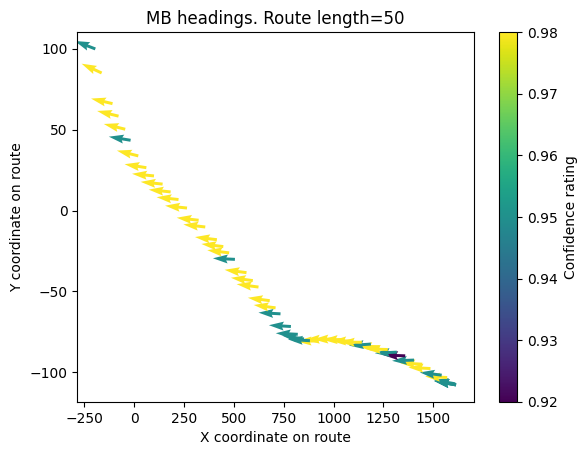

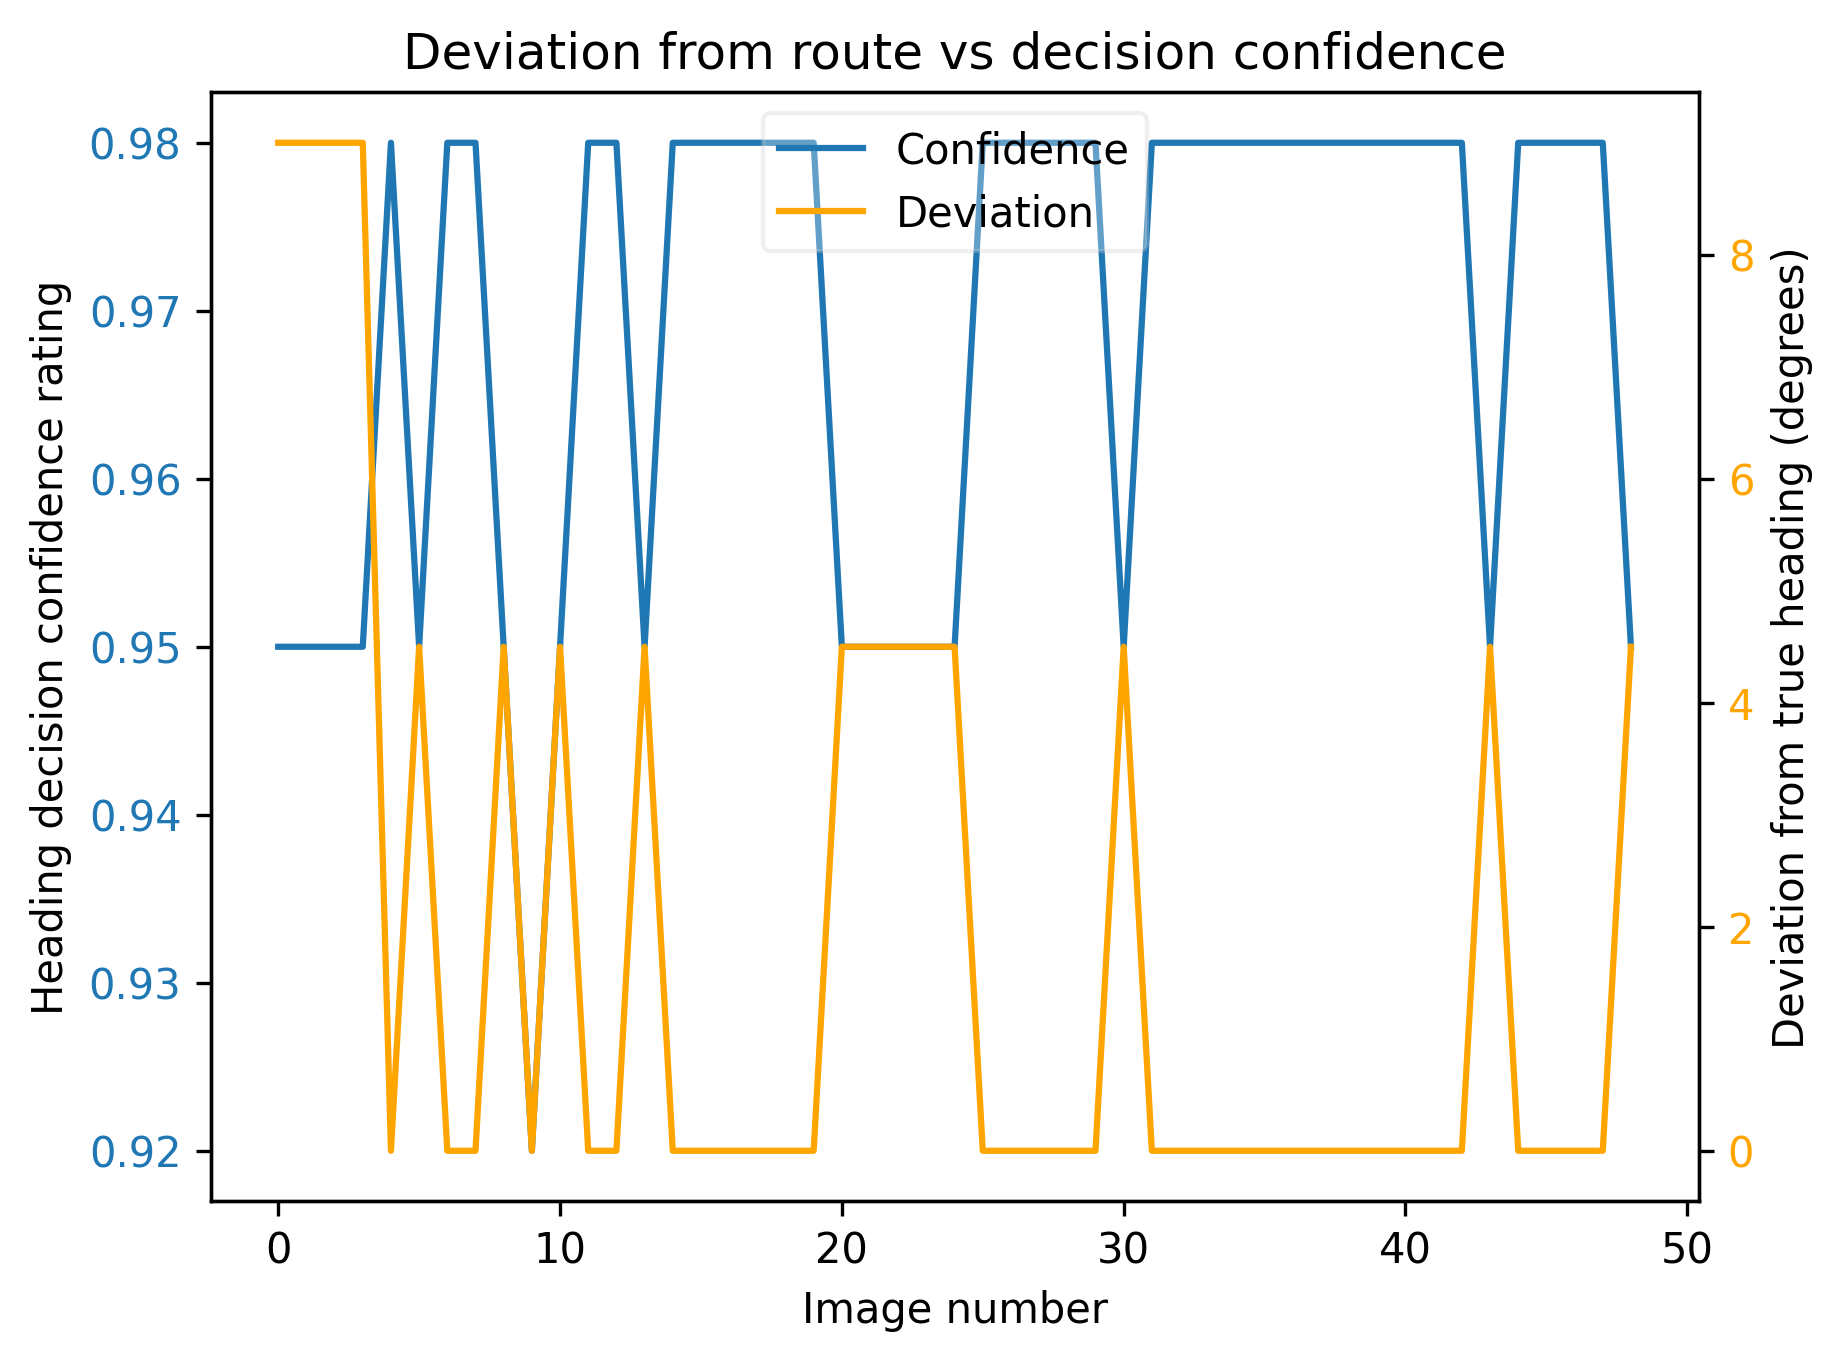

In [10]:
#example analysis
#get heading direction from each image
headings_df = calc_head_direction(test_activity)

#merge headings with meta file
master_df = merge_headings_meta(headings_df, "database_entries.csv", meta_source="ftl")

#plot headings of mb on the route
#plt.figure(dpi=1200) 
plot_mb_headings(master_df, offset=180)

#plot the deviation and confidence rating
plot_dev_conf(master_df, start=0, stop=-1)#, dpi=1200)